## Applying Principal Component Analysis (EOF)

- Subset the region of interest: PCA results are sensitive to domain.
- Calculate anomalies
- Check for missing values
- Weight the data by the sqrt( cosine ) of the latitude 
- Reshape to [time,space]

In [1]:
import numpy as np;
import xarray as xr;
import matplotlib.pyplot as plt;
from numpy import linalg as LA;

import cartopy.crs as ccrs;
import cartopy.mpl.ticker as cticker;
from cartopy.util import add_cyclic_point

In [2]:
## Read dataset into notebook.  
##Calculate the annual means simultaneously to remove the dominant effect of the seasonal cycle. This also decreases the amount of data in memory.  
#sst_path = '/shared/cmip5/data/piControl/ocean/mon/Omon/tos/NASA-GISS.GISS-E2-H/r1i1p1/';
atmos_path = '/shared/cmip5/data/piControl/atmos/mon/Amon/';
ts_path = atmos_path + '/ts/NASA-GISS.GISS-E2-H/r1i1p1/';
#pr_path = atmos_path + '/pr/NASA-GISS.GISS-E2-H/r1i1p1/';
#sst_file = 'tos_Omon_GISS-E2-H_piControl_r1i1p1_251001-255912.nc';
ts_file = 'ts_Amon_GISS-E2-H_piControl_r1i1p1_251001-255912.nc';
#pr_file =  'pr_Amon_GISS-E2-H_piControl_r1i1p1_251001-255912.nc';
#sst_ds = xr.open_mfdataset( ( sst_path + sst_file ), concat_dim = 'time' ).groupby( 'time.year' ).mean( dim = 'time' );
ts_ds = xr.open_mfdataset( ( ts_path + ts_file ), concat_dim = 'time' ).groupby( 'time.year' ).mean( dim = 'time' );
#pr_ds = xr.open_mfdataset( ( pr_path + pr_file ), concat_dim = 'time' ).groupby( 'time.year' ).mean( dim = 'time' );
##Convert precipitation from mm/s to mm/day
#pr_ds['pr'] = pr_ds['pr'] * 8.64 * ( 10 ** 4 );
ts_ds
## Note that there is no units attribute for this file.

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 90, lon: 144, year: 50)
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * year      (year) int64 2510 2511 2512 2513 2514 ... 2555 2556 2557 2558 2559
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    ts        (year, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>

In [3]:
new_lon = ( ts_ds['lon'] + 360 ) % 360;
ts_ds = ts_ds.assign_coords( lon = new_lon );
ts_ds = ts_ds.sortby( ts_ds['lon'] );
print( ts_ds );

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 90, lon: 144, year: 50)
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * year      (year) int64 2510 2511 2512 2513 2514 ... 2555 2556 2557 2558 2559
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    ts        (year, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>


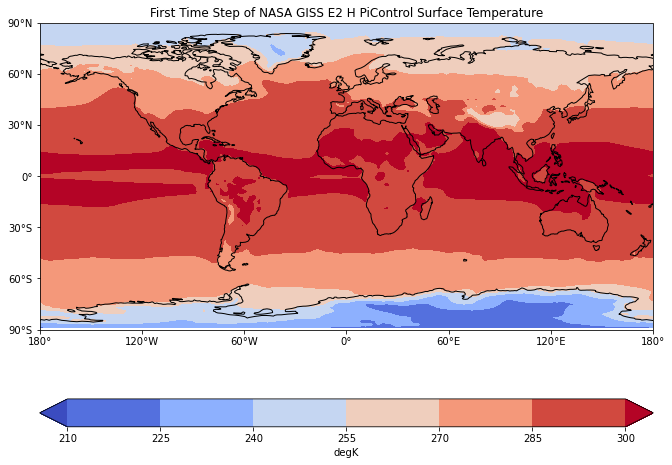

In [4]:
##Make the figure larger
fig = plt.figure( figsize = ( 11, 8.5 ) );

#Set the axes using the specified map projection
ax = plt.axes( projection = ccrs.PlateCarree() );

data, lons = add_cyclic_point( ts_ds['ts'][0,:,:], coord = ts_ds['lon'] );

#Make a filled contour plot
cs = ax.contourf( lons, ts_ds['lat'], data, transform = ccrs.PlateCarree(), cmap = 'coolwarm', extend = 'both' );
plt.title( 'First Time Step of NASA GISS E2 H PiControl Surface Temperature' );
##Add coastlines
ax.coastlines();

##Define the xticks for longitude
ax.set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
ax.xaxis.set_major_formatter( lon_formatter );

##Define the yticks for latitude
ax.set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
ax.yaxis.set_major_formatter( lat_formatter );

##Add colorbar
cbar = plt.colorbar( cs, label = 'degK', orientation = 'horizontal' );

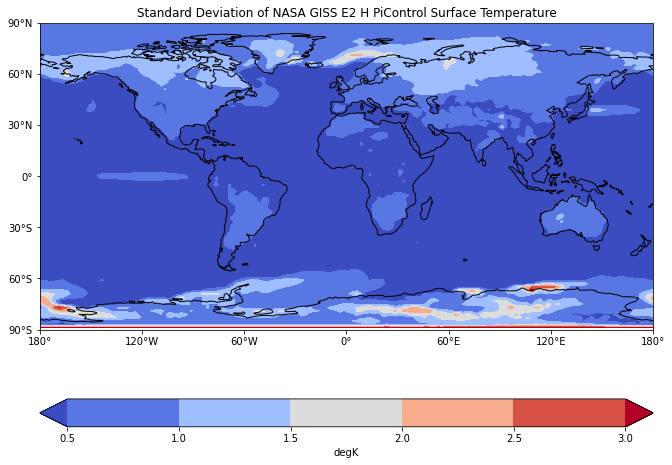

In [5]:
##Make the figure larger
fig = plt.figure( figsize = ( 11, 8.5 ) );

#Set the axes using the specified map projection
ax = plt.axes( projection = ccrs.PlateCarree() );

data, lons = add_cyclic_point( ts_ds['ts'].std( dim = 'year' ), coord = ts_ds['lon'] );

#Make a filled contour plot
cs = ax.contourf( lons, ts_ds['lat'], data, transform = ccrs.PlateCarree(), cmap = 'coolwarm', extend = 'both' );
plt.title( 'Standard Deviation of NASA GISS E2 H PiControl Surface Temperature' );
##Add coastlines
ax.coastlines();

##Define the xticks for longitude
ax.set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
ax.xaxis.set_major_formatter( lon_formatter );

##Define the yticks for latitude
ax.set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
ax.yaxis.set_major_formatter( lat_formatter );

##Add colorbar
cbar = plt.colorbar( cs, label = 'degK', orientation = 'horizontal' );

## Calculate Anomalies

In [6]:
ts_anom = ts_ds - ts_ds.mean( dim = 'year' );

In [7]:
coslat = np.cos( np.deg2rad( ts_ds.coords['lat'].values ) );
wgts = np.sqrt( coslat )[...,np.newaxis]; #Turns into a 2 dimensional array
wgts.shape

ts_anom['ts'] = ts_anom['ts'] * wgts;
#plt.contourf( ts_anom['ts'][0,:,:]);

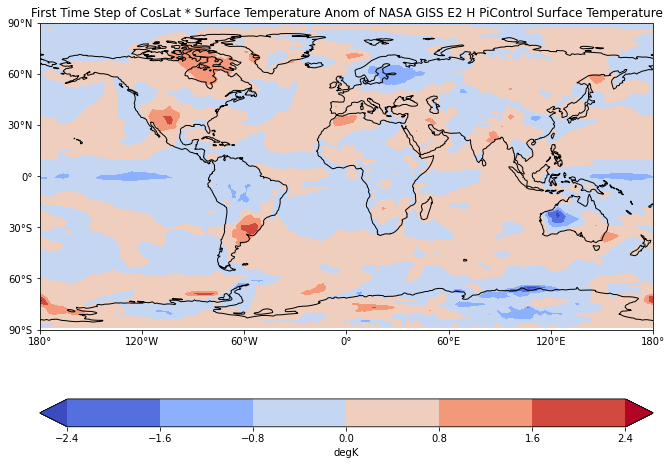

In [8]:
##Make the figure larger
fig = plt.figure( figsize = ( 11, 8.5 ) );

#Set the axes using the specified map projection
ax = plt.axes( projection = ccrs.PlateCarree() );

data, lons = add_cyclic_point( ts_anom['ts'][0,:,:], coord = ts_ds['lon'] );

#Make a filled contour plot
cs = ax.contourf( lons, ts_ds['lat'], data, transform = ccrs.PlateCarree(), cmap = 'coolwarm', extend = 'both' );
plt.title( 'First Time Step of CosLat * Surface Temperature Anom of NASA GISS E2 H PiControl Surface Temperature' );
##Add coastlines
ax.coastlines();

##Define the xticks for longitude
ax.set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
ax.xaxis.set_major_formatter( lon_formatter );

##Define the yticks for latitude
ax.set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
ax.yaxis.set_major_formatter( lat_formatter );

##Add colorbar
cbar = plt.colorbar( cs, label = 'degK', orientation = 'horizontal' );

In [9]:
nx = len( ts_anom['lon'] );
ny = len( ts_anom['lat'] );
nt = len( ts_anom['year'] );

In [10]:
X = np.reshape( ts_anom['ts'].values, ( ( nt, ny*nx ) ) );
X.shape

(50, 12960)

In [11]:
C = np.cov( X );
C.shape
##Output is [time,time]

(50, 50)

In [12]:
eigenvalues,eigenvectors = LA.eig( C );

In [13]:
idx = eigenvalues.argsort()[::-1]; #Last argument represents descending order
eigenvalues = eigenvalues[idx];
eigenvectors = eigenvectors[:,idx];

In [14]:
##Due to covariance matrix being [time,time], the PC time series are the eigenvectors
PC = eigenvectors;

In [15]:
#plt.plot( ts_anom['year'],PC[:,0] );

In [16]:
EOF = np.dot( X.T, PC );
EOF.shape

(12960, 50)

In [17]:
EOF = EOF.reshape( ( ny, nx, nt ) )
EOF.shape

(90, 144, 50)

In [18]:
EOF = EOF.T / wgts.squeeze();
EOF.shape

(50, 144, 90)

nrows = 3;
ncols = 1;
sf = [-1,-1,-1];
for i in np.arange( 3 ):
    ##Normalize the EOF corresponding to PC unit variance
    eofnorm = EOF[i,:,:].T * np.std( PC[:,i] );
    plt.subplot( nrows, ncols, i+1 );
    ##Use transpose to plot latitude on x, longitude on y
    plt.contourf( sf[i] * eofnorm, cmap = 'RdBu_r' );
    plt.colorbar();

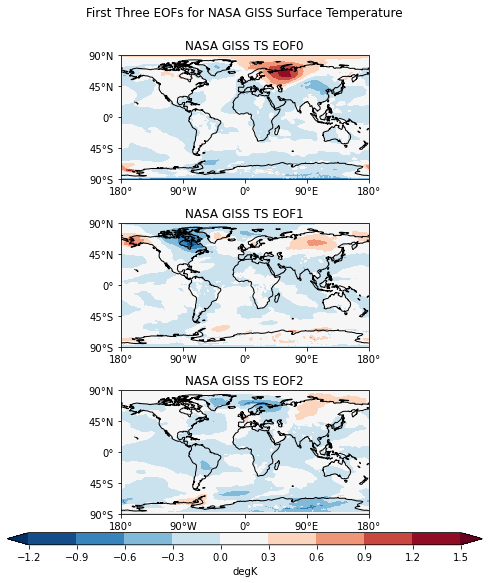

In [19]:
clevs = np.arange( -1.2, 1.5, 0.3 );
sf = [-1,-1,-1];

fig,axs = plt.subplots( nrows = 3, ncols = 1,
                      subplot_kw = {'projection':ccrs.PlateCarree() },
                      figsize = ( 11, 8.5) );
axs = axs.flatten();

for i in np.arange(3):
    eofnorm = EOF[i,:,:].T * np.std( PC[:,i] );
    
    data, lons = add_cyclic_point( sf[i] * eofnorm, coord = ts_anom['lon'] );

    cs = axs[i].contourf( lons, ts_anom['lat'],
                        data,
                        clevs,
                         transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
    #Longitude Labels
    axs[i].set_xticks( np.arange( -180, 181, 90 ), crs = ccrs.PlateCarree() );
    lon_formatter = cticker.LongitudeFormatter();
    axs[i].xaxis.set_major_formatter( lon_formatter );
    
    #Latitude Labels 
    axs[i].set_yticks( np.arange( -90, 91, 45 ), crs = ccrs.PlateCarree() );
    lat_formatter = cticker.LatitudeFormatter();
    axs[i].yaxis.set_major_formatter( lat_formatter );
    
    axs[i].coastlines();
    axs[i].set_title( 'NASA GISS TS EOF' + str( i ) );

#Reduce space between figures and leave space for a colorbar
fig.subplots_adjust( bottom = 0.15, top = 0.9,
                  left = 0.05, right = 0.95,
                  wspace = 0.05, hspace = 0.35)
cbar_ax = fig.add_axes( [0.2, 0.1, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal',
                   label = 'degK' );
fig.suptitle( 'First Three EOFs for NASA GISS Surface Temperature' );

In [20]:
(sf[i] * eofnorm).shape

(90, 144)

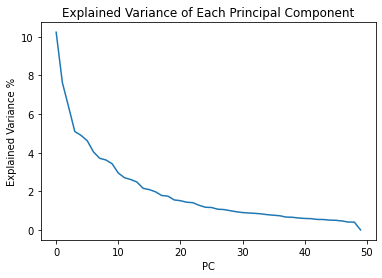

In [21]:
##Variance explained by each EOF/PC pair is represented by the eigenvalue divided by the sum of eigenvalues (total variance)
vexp = ( eigenvalues / np.sum( eigenvalues ) ) * 100;
plt.plot( vexp );
plt.title( 'Explained Variance of Each Principal Component' );
plt.xlabel( 'PC' );
plt.ylabel( 'Explained Variance %' );

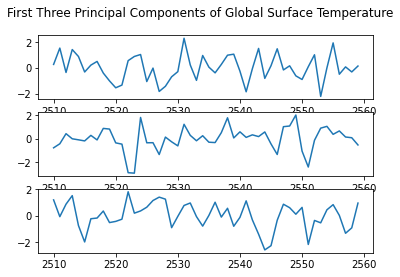

In [22]:
nrows = 3;
ncols = 1;
for i in np.arange( 3 ):
    ##Normalize the Principal Components to unit variance
    pcnorm = PC[:,i]/np.std( PC[:,i] );
    plt.subplot( nrows, ncols, i+1 );
    plt.plot( ts_anom['year'], pcnorm * sf[i] );

plt.suptitle( 'First Three Principal Components of Global Surface Temperature' );


## Select North Atlantic (Domain of Interest)

In [23]:
ts_na = ts_anom.sel( lat = slice( 0, 60 ),
                     lon = slice( 360-80, 360 ) );
#plt.contourf( ts_na['ts'][0,:,:] );
#plt.colorbar();

In [24]:
coslat = np.cos( np.deg2rad( ts_na.coords['lat'].values ) );
wgts = np.sqrt( coslat )[...,np.newaxis]; #Turns into a 2 dimensional array
wgts.shape

ts_na['ts'] = ts_na['ts'] * wgts;
#plt.contourf( ts_na['ts'][0,:,:]);

In [25]:
ts_na

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 30, lon: 32, year: 50)
Coordinates:
  * lat       (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 51.0 53.0 55.0 57.0 59.0
  * lon       (lon) float64 281.2 283.8 286.2 288.8 ... 351.2 353.8 356.2 358.8
  * year      (year) int64 2510 2511 2512 2513 2514 ... 2555 2556 2557 2558 2559
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 30, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 32, 2), meta=np.ndarray>
    ts        (year, lat, lon) float64 dask.array<chunksize=(1, 30, 32), meta=np.ndarray>

## Reshape to [time,space]

In [26]:
nx = len( ts_na['lon'] );
ny = len( ts_na['lat'] );
nt = len( ts_na['year'] );

In [27]:
X = np.reshape( ts_na['ts'].values, ( ( nt, ny*nx ) ) );
X.shape

(50, 960)

## Calculate EOFs

### Calculate the Covariance Matrix

$C = \frac{1}{N} X^T X$
- C =  np.matul( X.T, X ) / N;

In [28]:
C = np.cov( X );
C.shape
##Output is [time,time]

(50, 50)

### Calculate Eigenvectors and Eigenvalues

In [29]:
eigenvalues,eigenvectors = LA.eig( C );

In [30]:
idx = eigenvalues.argsort()[::-1]; #Last argument represents descending order
eigenvalues = eigenvalues[idx];
eigenvectors = eigenvectors[:,idx];

### PC Time Series

In [31]:
eigenvectors.shape

(50, 50)

In [32]:
##Due to covariance matrix being [time,time], the PC time series are the eigenvectors
PC = eigenvectors;

In [33]:
#plt.plot( ts_anom['year'],PC[:,0] );

### EOF Spatial Patterns

In [34]:
EOF = np.dot( X.T, PC );
EOF.shape

(960, 50)

In [35]:
EOF = EOF.reshape( ( ny, nx, nt ) )
EOF.shape

(30, 32, 50)

In [36]:
EOF = EOF.T / wgts.squeeze();
EOF.shape

(50, 32, 30)

nrows = 3;
ncols = 1;
sf = [-1,-1,-1];
for i in np.arange( 3 ):
    ##Normalize the EOF corresponding to PC unit variance
    eofnorm = EOF[i,:,:].T * np.std( PC[:,i] );
    plt.subplot( nrows, ncols, i+1 );
    ##Use transpose to plot latitude on x, longitude on y
    plt.contourf( sf[i] * eofnorm, cmap = 'RdBu_r' );
    plt.colorbar();

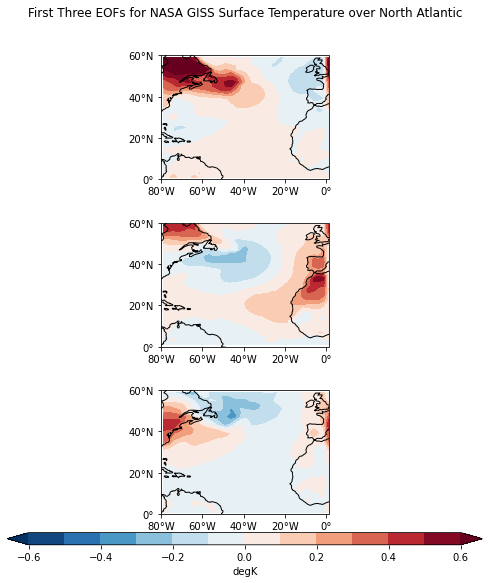

In [37]:
clevs = np.arange( -0.6, 0.7, 0.1 );
sf = [1,-1,-1];

fig,axs = plt.subplots( nrows = 3, ncols = 1,
                      subplot_kw = {'projection':ccrs.PlateCarree() },
                      figsize = ( 11, 8.5) );
axs = axs.flatten();

for i in np.arange(3):
    eofnorm = EOF[i,:,:].T * np.std( PC[:,i] );
    
    data, lons = add_cyclic_point( sf[i] * eofnorm, coord = ts_na['lon'] );

    cs = axs[i].contourf( lons, ts_na['lat'],
                        data,
                        clevs,
                         transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
    #Longitude Labels
    axs[i].set_xticks( np.arange( -80, 1, 20 ), crs = ccrs.PlateCarree() );
    lon_formatter = cticker.LongitudeFormatter();
    axs[i].xaxis.set_major_formatter( lon_formatter );
    
    #Latitude Labels 
    axs[i].set_yticks( np.arange( 0, 61, 20 ), crs = ccrs.PlateCarree() );
    lat_formatter = cticker.LatitudeFormatter();
    axs[i].yaxis.set_major_formatter( lat_formatter );
    
    axs[i].coastlines();
#    axs[i].set_title( mon.values );

#Reduce space between figures and leave space for a colorbar
fig.subplots_adjust( bottom = 0.15, top = 0.9,
                  left = 0.05, right = 0.95,
                  wspace = 0.05, hspace = 0.35)
cbar_ax = fig.add_axes( [0.2, 0.1, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal',
                   label = 'degK' );
fig.suptitle( 'First Three EOFs for NASA GISS Surface Temperature over North Atlantic' );

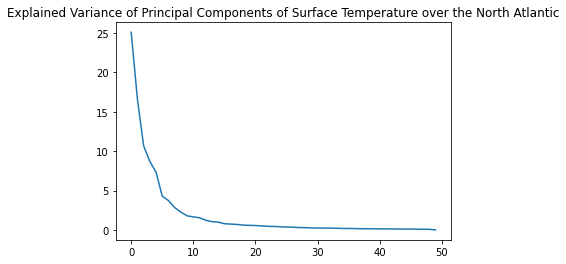

In [38]:
##Variance explained by each EOF/PC pair is represented by the eigenvalue divided by the sum of eigenvalues (total variance)
vexp = ( eigenvalues / np.sum( eigenvalues ) ) * 100;
plt.plot( vexp );
plt.title( 'Explained Variance of Principal Components of Surface Temperature over the North Atlantic' );

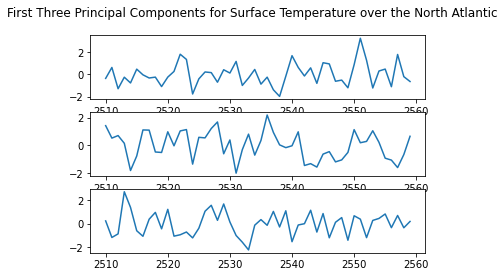

In [39]:
for i in np.arange( 3 ):
    ##Normalize the Principal Components to unit variance
    pcnorm = PC[:,i]/np.std( PC[:,i] );
    plt.subplot( nrows, ncols, i+1 );
    plt.plot( ts_anom['year'], pcnorm * sf[i] );
    
plt.suptitle( 'First Three Principal Components for Surface Temperature over the North Atlantic' );    